## Welcome to the Day Two ML tutorial

### Machine learning algorithms for identifying antibiotic resistant bacteria

**Instructor:** [Nicole Wheeler](https://twitter.com/nwheeler443) - Data Scientist at the [Centre for Genomic Pathogen Surveillance](https://www.pathogensurveillance.net/)

---

In this module, you will learn how to train machine learning models for predicting antibiotic resistance in bacteria. 

We will be focussing on a species called _Neisseria gonorrhoeae_, the bacteria which cause gonorrhoea. Gonorrhoea is the second most common sexually transmitted infection (STI) in Europe, after chlamydia. Rates of gonorrhoea infection are on the rise, with a 26% increase reported from 2017-2018 in the UK. 

Many people who are infected (especially women) experience no symptoms, helping the disease to spread. If the infection is left untreated, it can lead to infertility in women, and can occasionally spread to other parts of the body such as your joints, heart valves, brain or spinal cord.

Resistance of these bacteria to antibiotics is rising over time, making infections hard to treat. Below, you can see rates of resistance to different antibiotics. Image is from this paper: https://www.mdpi.com/2079-6382/7/3/60.
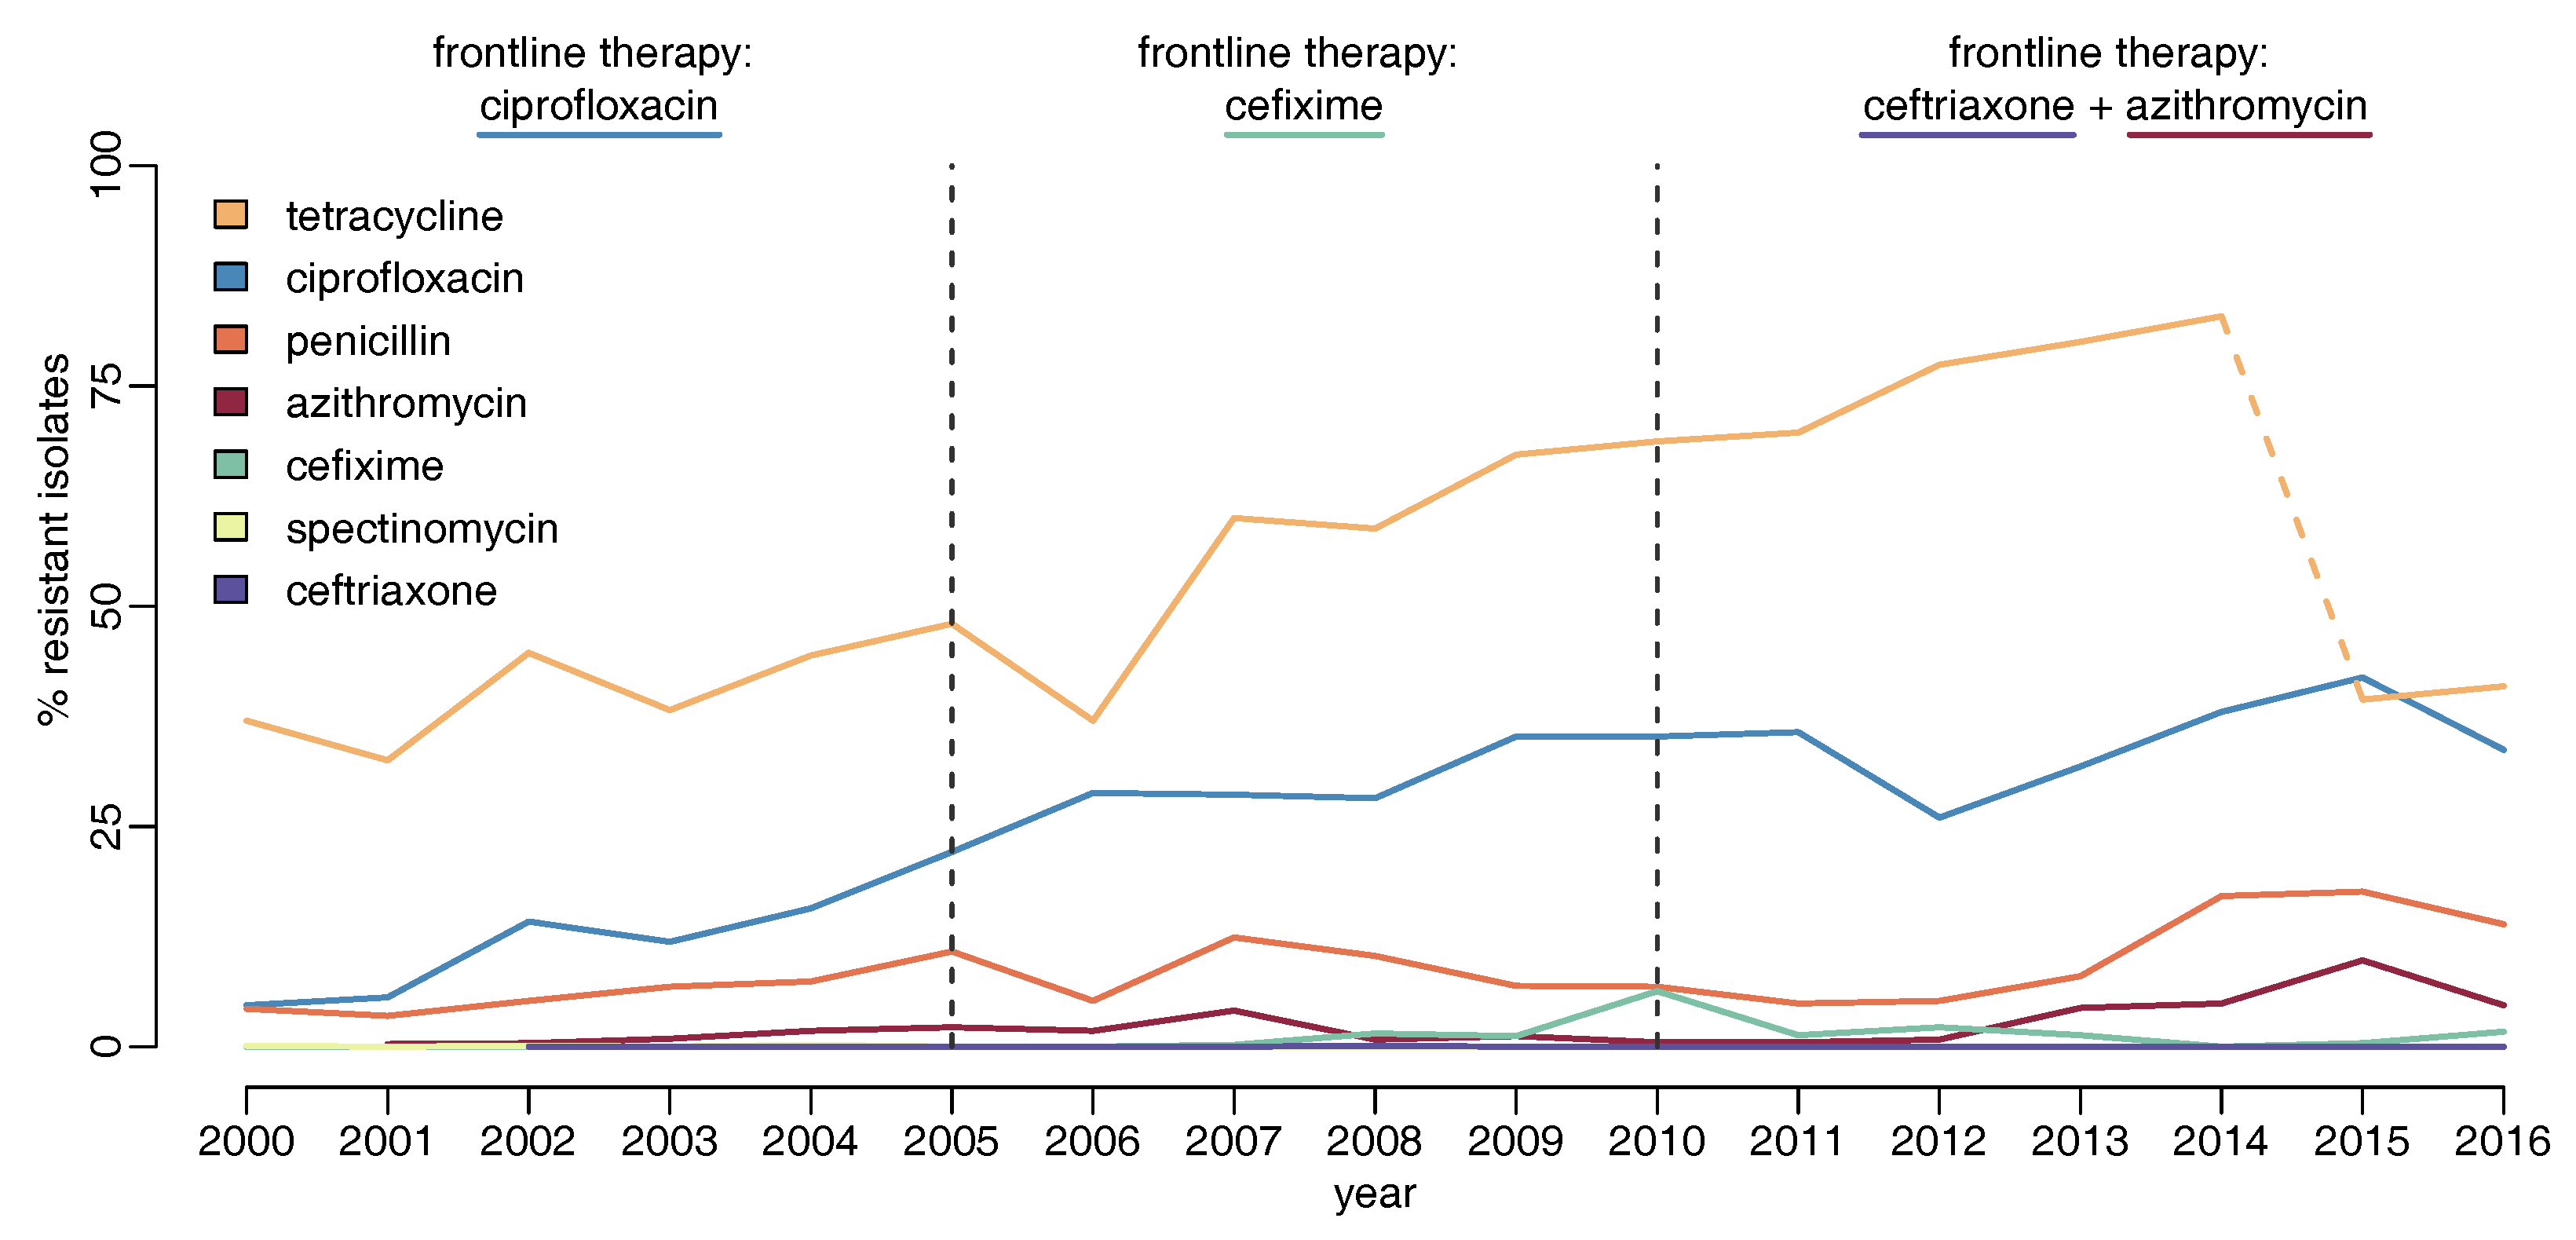
In the past, patients were treated with an antibiotic called ciprofloxaxcin. Doctors had to stop using this antibiotic because resistance to the drug became too common, causing treatments of infections to fail. Until very recently, the recommended treatment was two drugs - ceftriaxone and azithromycin. Azithromycin was removed from recommendations because of concern over rising resistance to the antibiotic. In February 2018, the first ever reported case of resistance to treatment with ceftriaxone and azithromycin, as well as resistance to the last-resort treatment spectinomycin, was reported. Currently in the UK, patients are only treated with ceftriaxone.  

In this notebook, we will look at machine learning algorithms for predicting resistance to __ciprofloxacin__. 

In [ ]:
# set up environment
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sb
import time

For this exercise, we have genome sequence and antibiotic resistance data gathered from different publicly available sources. If you'd like to learn more about the collection, an interactive view of the data can be accessed [here](https://microreact.org/project/N_gonorrhoeae). 

For this analysis, we're using **unitigs**, stretches of DNA shared by a subset of the strains in our study. Unitigs are an efficient but flexible way of representing DNA variation in bacteria. If you'd like to learn more about unitigs, and how this dataset was constructed, have a look at [this paper](https://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1007758).

The full dataset consists of 584,362 unitigs, which takes a long time to train models on, so for this exercise we will be using a set that has been filtered for unitigs associated with resistance. 

In [ ]:
# a function for preparing our training and testing data
def prep_data(phenotype) :
    pheno = pd.read_csv('../input/gono-unitigs/metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype]) # drop samples that don't have a value for our chosen resistance profile
    pheno = pheno[phenotype]
    
    # read in unitig data
    X = pd.read_csv('../input/gono-unitigs/' + phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)] # only keep rows with a resistance measure
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno


Here, we read in the data for our analysis. We will be starting with models to predict ciprofloxacin resistance. 

In [ ]:
# prepare our data for predicting ciprofloxacin resistance
phenotype = 'cip_sr'
X, pheno = prep_data(phenotype)

# create an array for storing performance metrics
performance = []
method = []
times = []

In [ ]:
# look at the length distribution of the unitigs in our dataset
unitigs = X.columns
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)

## Model training

We will start will building some basic models for ciprofloxacin resistance. This resistance pattern can mostly be explained by a single mutation, so is likely to be impacted by the amount of noise each method incorporates. 

In [ ]:
# function for fitting a model
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :
    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()
        
        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]
        
        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)
        
        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)
        y_pred[y_pred<0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times


Now that we have our data organised, we can start fitting models. First we will try an elastic net logistic regression. 

In [ ]:
enet = SGDClassifier(loss="log", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)

Next, we will try a support vector machine.

In [ ]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

Now we will try XGBoost. 

In [ ]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4], 
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1], 
    'learning_rate': [0.01, 0.1], 
    'max_depth': [2], 
    'objective': ['binary:hinge'], 
    'subsample': [0.2, 0.4, 0.6]
}

xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)

And finally, a random forest.

In [ ]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)

In [ ]:
# compare results from the different predictors
sb.set_context("talk")
plt.title("Model Performance - Ciprofloxacin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha="right")

In [ ]:
# took at the time taken to train the different models
sb.set_context("talk")
plt.title("Model Training Times - Ciprofloxacin Resistance", y=1.08)
sb.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Time taken for training")
plt.xticks(rotation=30, ha="right")


This is a basic workflow for building predictive models. Now you have some options for next steps. The other things you can do in the following sections are:
* Look into what your model has learned, and whether this fits with our existing knowledge of antibiotic resistance
* Examine how much we'd benefit from collecting more samples
* Explore the impact of genetic relatedness on accuracy measures

Alternatively, you can go back and try the following:
* Explore more hyper-parameters and try to build more accurate models
* Try some other model types
* Try using these unitigs to predict resistance to another antibiotic included in metadata.csv

Select one that sounds interesting to you.

Or, you can read more about antibiotic resistance:
* [The impact of antibiotic resistance on modern medicine](https://medium.com/@nwheeler443/the-unmeasured-cost-of-antibiotic-resistance-7de8dc41ea41)
* [Phage therapy, a possible solution to the antibiotic resistance crisis](https://medium.com/@nwheeler443/phage-therapy-a-solution-to-the-antibiotic-resistance-crisis-e0ec34309a5)
* [Should machine learning algorithms guide antibiotic prescribing?](https://towardsdatascience.com/should-machine-learning-algorithms-guide-antibiotic-prescribing-f74753e28472)

## Exploring what the model has learned

In [ ]:
# function for looking at SVM feature importance
sb.set_context("talk")
def plot_coefficients(classifier, feature_names, top_features=5):
    coef = classifier.best_estimator_.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(10, 5))
    plt.title("Feature Importances (Support Vector Machine) - Ciprofloxacin Resistance", y=1.08)
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    np.asarray(feature_names)[top_positive_coefficients]

plot_coefficients(svm_model, list(X.columns))

# if we print the unitigs, we can then look at what genes they relate to
coef = svm_model.best_estimator_.coef_.ravel()
feature_names = list(X.columns)
top_negative_coefficients = np.argsort(coef)[:5]
print("Top negative predictors: ", np.asarray(feature_names)[top_negative_coefficients])

top_positive_coefficients = np.argsort(coef)[-5:]
print("Top positive predictors: ", np.asarray(feature_names)[top_positive_coefficients])

You can take the unitigs from above, and input one into this search algorithm: https://www.uniprot.org/blast or https://card.mcmaster.ca/analyze/blast to see if it comes from a known protein or resistance mechanism. The search has to be formatted like this for CARD:

```
>sequence
[unitig]
```

and you will need to choose the BLASTN option for the query to be processed correctly.

If you want to look into the biology more, try [this link](https://blast.ncbi.nlm.nih.gov/Blast.cgi?PAGE_TYPE=BlastSearch&USER_FORMAT_DEFAULTS=on&SET_SAVED_SEARCH=true&PAGE=MegaBlast&PROGRAM=blastn&GAPCOSTS=0%200&MATCH_SCORES=1,-2&DATABASE=nt_v5&BLAST_PROGRAMS=megaBlast&MAX_NUM_SEQ=100&SHORT_QUERY_ADJUST=on&EXPECT=10&WORD_SIZE=28&REPEATS=repeat_9606&TEMPLATE_TYPE=0&TEMPLATE_LENGTH=0&FILTER=L&FILTER=m&EQ_MENU=Neisseria%20gonorrhoeae%20%28taxid%3A485%29&PROG_DEFAULTS=on&SHOW_OVERVIEW=on&SHOW_LINKOUT=on&ALIGNMENT_VIEW=Pairwise&MASK_CHAR=2&MASK_COLOR=1&GET_SEQUENCE=on&NUM_OVERVIEW=100&DESCRIPTIONS=100&ALIGNMENTS=100&FORMAT_OBJECT=Alignment&FORMAT_TYPE=HTML), to see where the unitigs can be found in a publicly available collection of genomes. 

Now let's do the same for the random forest. 

In [ ]:
importances = rf_model.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:10]

# Plot the feature importances of the forest
sb.set_context("talk")
plt.figure(figsize=(10, 5))
plt.title("Feature Importances (Random Forest) - Ciprofloxacin Resistance")
plt.bar(range(10), importances[indices],
       color="crimson", yerr=std[indices], align="center")
plt.xticks(range(10), np.asarray(feature_names)[indices], rotation=60, ha='right')
plt.xlim([-1, 10])
plt.show()

feature_names = list(X.columns)
print("Top predictors: ", np.asarray(feature_names)[indices])

## Should we collect more samples?

Here, we will construct a learning curve to see how much performance improves as we include more of our sample set, and whether performance gains have levelled off, suggesting that collecting more samples won't help, or whether it's still improving. 

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    sb.set_context("talk")
    plt.figure(figsize=(7, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Balanced accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="balanced_accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(color='gainsboro')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="crimson")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="cornflowerblue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="cornflowerblue",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [ ]:
title = "Learning Curve (Random forest) - Ciprofloxacin resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(max_features=round(X.shape[1]*0.5), n_jobs=-1, max_depth=3, n_estimators=50)
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

In [ ]:
title = "Learning Curve (Support vector machine) - Ciprofloxacin resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = SVC(C=0.01, gamma=1e-06, kernel='linear')
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()